Establish drive file stream:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports:

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable
import time
import copy
import numpy as np
from torchvision import datasets, models, transforms
from PIL import Image
import torch.nn.functional as F
import seaborn as sn
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from graphviz import Digraph
import random

Defining dataset:

In [ ]:
class PatientDataset(Dataset):

  def __init__(self, sourceFolder, input_size, phase):
    self.patients = []
    self.classes = []
    self.classIdx = []
    for dir in os.listdir(sourceFolder):
      if '.' not in dir:
        self.patients.append(os.path.join(sourceFolder, dir))
        label = dir.split('_')[0]
        classFound = False
        for i in range(len(self.classes)):
          if label in self.classes[i]:
            self.classIdx.append(i)
            classFound = True
            break
        if not classFound:
          # print('New class found: ' + label)
          self.classes.append(label)
          self.classIdx.append(len(self.classes) - 1)
    self.patientSamples = []
    self.cntPerClass = [0] * len(self.classes)
    for i in range(len(self.classIdx)):
      self.cntPerClass[self.classIdx[i]] += 1
      self.patientSamples.append((self.patients[i], self.classIdx[i]))
    print(self.classes)
    self.weightsPerClasses = [0] * len(self.classes)
    for i in range(len(self.cntPerClass)):
      self.weightsPerClasses[i] = 1 / (self.cntPerClass[i] / len(self.classIdx))
    print(self.weightsPerClasses)
    print(self.classIdx)
    for i in range(len(self.classes)):
      print(self.classes[i])
      cnt = 0
      for c in self.classIdx:
        if (c == i):
          cnt += 1
      print(cnt)  



    if 'train' in phase:
          self.SATransforms = transforms.Compose([
                transforms.Grayscale(),
                transforms.CenterCrop(input_size),
                transforms.RandomRotation(10),
                transforms.RandomPerspective(0.1),
                transforms.ToTensor(),
                transforms.Normalize([0.1858], [0.1787])]
          )
          self.CH2Transforms = transforms.Compose([
              transforms.Grayscale(),
              transforms.CenterCrop(input_size),
              transforms.RandomRotation(10),
              transforms.RandomPerspective(0.1),
              transforms.ToTensor(),
              transforms.Normalize([0.1635], [0.2076])]
          )
          self.CH3Transforms = transforms.Compose([
              transforms.Grayscale(),
              transforms.CenterCrop(input_size),
              transforms.RandomRotation(10),
              transforms.RandomPerspective(0.1),
              transforms.ToTensor(),
              transforms.Normalize([0.1613], [0.2128])]
          )
          self.CH4Transforms = transforms.Compose([
              transforms.Grayscale(),
              transforms.CenterCrop(input_size),
              transforms.RandomRotation(10),
              transforms.RandomPerspective(0.1),
              transforms.ToTensor(),
              transforms.Normalize([0.1683], [0.2181])]
          )
    else:
          self.SATransforms = transforms.Compose([
                transforms.Grayscale(),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.1858], [0.1787])]
          )
          self.CH2Transforms = transforms.Compose([
                transforms.Grayscale(),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.1635], [0.2076])]
          )
          self.CH3Transforms = transforms.Compose([
                transforms.Grayscale(),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.1613], [0.2128])]
          )
          self.CH4Transforms = transforms.Compose([
                transforms.Grayscale(),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.1683], [0.2181])]
          )

  def __getitem__(self, index):
      sa_tensor = None
      ch2_tensor = None
      ch3_tensor = None
      ch4_tensor = None
      # for dir in os.listdir(self.patients[index]):
      #   print(os.listdir(self.patients[index]))
      #   if 'SA' in dir:
      #     subDir = os.path.join(self.patients[index], dir)
      #     for file in os.listdir(subDir):
      #       sa_tensor = Image.open(os.path.join(subDir, file))
      #       sa_tensor = self.SATransforms(sa_tensor)
      #   if 'CH2' in dir:
      #     subDir = os.path.join(self.patients[index], dir)
      #     for file in os.listdir(subDir):
      #       ch2_tensor = Image.open(os.path.join(subDir, file))
      #       ch2_tensor = self.CH2Transforms(ch2_tensor)
      #   if 'CH3' in dir:
      #     subDir = os.path.join(self.patients[index], dir)
      #     for file in os.listdir(subDir):
      #       ch3_tensor = Image.open(os.path.join(subDir, file))
      #       ch3_tensor = self.CH3Transforms(ch3_tensor)
      #   if 'CH4' in dir:
      #     subDir = os.path.join(self.patients[index], dir)
      #     for file in os.listdir(subDir):
      #       ch4_tensor = Image.open(os.path.join(subDir, file))
      #       ch4_tensor = self.CH4Transforms(ch4_tensor)
      # print('Started os walk')
      saFolder = os.path.join(self.patients[index], 'SA')
      sa_tensor = Image.open(os.path.join(saFolder, os.listdir(saFolder)[0]))
      sa_tensor = self.SATransforms(sa_tensor)
      ch2Folder = os.path.join(self.patients[index], 'CH2')
      ch2_tensor = Image.open(os.path.join(ch2Folder, os.listdir(ch2Folder)[0]))
      ch2_tensor = self.CH2Transforms(ch2_tensor)
      ch3Folder = os.path.join(self.patients[index], 'CH3')
      ch3_tensor = Image.open(os.path.join(ch3Folder, os.listdir(ch3Folder)[0]))
      ch3_tensor = self.CH3Transforms(ch3_tensor)
      ch4Folder = os.path.join(self.patients[index], 'CH4')
      ch4_tensor = Image.open(os.path.join(ch4Folder, os.listdir(ch4Folder)[0]))
      ch4_tensor = self.CH4Transforms(ch4_tensor)
      # print('Finished os walk, starting tensor build')
      # catTensor = torch.empty(4, sa_tensor.shape[0], sa_tensor.shape[1], sa_tensor.shape[2])
      # catTensor[0] = sa_tensor
      # catTensor[1] = ch2_tensor
      # catTensor[2] = ch3_tensor
      # catTensor[3] = ch4_tensor
      catArray = [sa_tensor, ch2_tensor, ch3_tensor, ch4_tensor]
      # print('Finished tensor build')
      return catArray, self.classIdx[index]

  def __len__(self):
    return len(self.patients)



Defining autoencoder:

In [ ]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 24, 5, padding=2),
            nn.LeakyReLU(0.05, inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(24, 12, 3, padding=1),
            nn.LeakyReLU(0.05, inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(12, 6, 3, padding=1),
            nn.LeakyReLU(0.05, inplace=True),
            nn.MaxPool2d(2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(6, 6, 3, padding=1),
            nn.LeakyReLU(0.05, inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(6, 12, 3, padding=1),
            nn.LeakyReLU(0.05, inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(12, 24, 3, padding=1),
            nn.LeakyReLU(0.05, inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(24, 1, 5, padding=2),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Defining ensemble model:

In [ ]:
class AxisEnsemble(nn.Module):
  def __init__(self, num_of_classes, class_SA_model, class_CH2_model,
               class_CH3_model, class_CH4_model, AEModel_SA, AEModel_CH2,
               AEModel_CH3, AEModel_CH4):
    super(AxisEnsemble, self).__init__()
    self.class_SA_model = class_SA_model
    self.class_CH2_model = class_CH2_model
    self.class_CH3_model = class_CH3_model
    self.class_CH4_model = class_CH4_model
    self.AEModel_SA = AEModel_SA
    self.AEModel_CH2 = AEModel_CH2
    self.AEModel_CH3 = AEModel_CH3
    self.AEModel_CH4 = AEModel_CH4
    self.classifier = nn.Linear(num_of_classes*4, num_of_classes)

  def forward(self, x1, x2, x3, x4):
    x1_extracted = self.AEModel_SA(x1)
    x2_extracted = self.AEModel_CH2(x2)
    x3_extracted = self.AEModel_CH3(x3)
    x4_extracted = self.AEModel_CH4(x4)
    x1 = torch.abs(x1 - x1_extracted)
    x2 = torch.abs(x2 - x2_extracted)
    x3 = torch.abs(x3 - x3_extracted)
    x4 = torch.abs(x4 - x4_extracted)
    x1_rgb = torch.empty(x1.shape[0], 3, x1.shape[2], x1.shape[3])
    x2_rgb = torch.empty(x2.shape[0], 3, x2.shape[2], x2.shape[3])
    x3_rgb = torch.empty(x3.shape[0], 3, x3.shape[2], x3.shape[3])
    x4_rgb = torch.empty(x3.shape[0], 3, x4.shape[2], x4.shape[3])
    x1_rgb[:] = x1
    x2_rgb[:] = x2
    x3_rgb[:] = x3
    x4_rgb[:] = x4
    x1_rgb = x1_rgb.to(device)
    x2_rgb = x2_rgb.to(device)
    x3_rgb = x3_rgb.to(device)
    x4_rgb = x4_rgb.to(device)
    x1_out = self.class_SA_model(x1_rgb)
    x2_out = self.class_CH2_model(x2_rgb)
    x3_out = self.class_CH3_model(x3_rgb)
    x4_out = self.class_CH4_model(x4_rgb)
    x = torch.cat((x1_out, x2_out, x3_out, x4_out), dim=1)
    # x = x1_out
    x = self.classifier(x)
    return x

    

Helper function for model intialization:

In [ ]:
def initialize_model(num_classes):
    model = models.resnet18(pretrained=True, progress=True)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(num_features, 256),
        # nn.Dropout(0.2),
        nn.Linear(256, num_classes)
    )
    # model.layer1.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.2, training=m.training))
    # model.layer3.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.2, training=m.training))
    # children = model.children()
    # child_cntr = 0
    # for child in children:
    #   child_cntr += 1
    #   if child_cntr == 5 or child_cntr == 7:
    #     for param in child.parameters():
    #       param.requires_grad = False
    #   if child_cntr > 7:
    #     break

    params_to_update = model.parameters()
    freeze_percent = 0.2

    param_cnt = 0
    for param in params_to_update:
      param_cnt += 1
    cur_param_cnt = 0
    params_to_update = model.parameters()
    for param in params_to_update:
      if cur_param_cnt < param_cnt*freeze_percent:
        print("freezing param")
        print(param)
        param.requires_grad = False
      cur_param_cnt += 1  
    
    return model

In [ ]:
def make_dot(var, params=None):
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style="filled", shape="box", align="left", fontsize="12", ranksep="0.1", height="0.2")
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return "(" + (", ").join(["%d" % v for v in size]) + ")"

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor="orange")
                dot.edge(str(id(var.grad_fn)), str(id(var)))
                var = var.grad_fn
            if hasattr(var, "variable"):
                u = var.variable
                name = param_map[id(u)] if params is not None else ""
                node_name = "%s\n %s" % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor="lightblue")
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, "next_functions"):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, "saved_tensors"):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)

    add_nodes(var)
    return dot

Function for fine-tuning model:

In [ ]:
def train_classification(classModel, dataloaders, criterion,
                         optimizer, scheduler, num_epochs=20):


    since = time.time()

    val_acc_history = []
    train_acc_history = []

    val_f1_history = []
    train_f1_history = []

    val_loss_history = []
    train_loss_history = []

    train_recall_history = []
    train_precision_history = []

    best_model_wts = copy.deepcopy(classModel.state_dict())
    best_overall_loss = 10000.0
    acc_at_best_loss = 0.0
    f1_at_best_loss = 0.0
    loss_at_best_acc = 10000.0
    f1_at_best_acc = 0.0
    loss_at_best_f1 = 10000.0
    acc_at_best_f1 = 0.0
    best_acc = 0.0
    best_f1 = 0.0
    best_recall = 0.0
    best_precision = 0.0
    best_loss = 10000.0
    best_loss_preds, best_loss_targets = [], []
    best_f1_preds, best_f1_targets = [], []
    best_acc_preds, best_acc_targets = [], []
    training_acc_at_best_val_loss = 0.0
    training_f1_at_best_val_loss = 0.0
    training_loss_at_best_val_loss = 10000.0
    training_acc_at_best_val_acc = 0.0
    training_f1_at_best_val_acc = 0.0
    training_loss_at_best_val_acc = 10000.0
    training_acc_at_best_val_f1 = 0.0
    training_f1_at_best_val_f1 = 0.0
    training_loss_at_best_val_f1 = 10000.0
    training_recall_at_best_val_f1 = 0.0
    training_precision_at_best_val_f1 = 0.0

    epochs_without_upgrade = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        prev_train_loss = 10000.0

        # Each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            if phase == 'training':
                classModel.train()  # Set model to training mode
            else:
                classModel.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            tmp_preds, tmp_targets = [], []
            tmp_preds_arr, tmp_targets_arr = [], []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # print('Started batch')
                saInputs, ch2Inputs, ch3Inputs, ch4Inputs = inputs
                saInputs = saInputs.to(device)
                ch2Inputs = ch2Inputs.to(device)
                ch3Inputs = ch3Inputs.to(device)
                ch4Inputs = ch4Inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'training'):
                    # Get model outputs and calculate loss
                    outputs = classModel(saInputs, ch2Inputs, ch3Inputs, ch4Inputs)

                    # g = make_dot(outputs)
                    # g.view()

                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    # print('Predictions: ')
                    # print(preds)

                    # backward + optimize only if in training phase
                    if phase == 'training':
                        #L1 regularization
                        # all_weights = []
                        # for name, param in classModel.named_parameters():
                        #   if 'weight' in name:
                        #     all_weights.append(param.view(-1))
                        # # print('weight num: {}'.format(len(all_weights)))
                        # all_weights_params = torch.cat(all_weights)
                        # l1_regularization = 0.001 * torch.norm(all_weights_params, 1)

                        # loss = loss + l1_regularization

                        loss.backward()
                        optimizer.step()
                        # loss = loss - l1_regularization

                # statistics
                running_loss += loss.item() * inputs[0].size(0)
                running_corrects += torch.sum(preds == labels)

                detached_pred = preds.detach().cpu().numpy()
                detached_target = labels.detach().cpu().numpy()

                tmp_preds_arr.append(detached_pred)
                tmp_targets_arr.append(detached_target)
                # print('Size of pred: {}'.format(detached_pred.shape))
                # print('Size of target: {}'.format(detached_target.shape))
                # print(detached_pred)
                # print(detached_target)

                for i in range(detached_pred.shape[0]):
                    tmp_preds.append(detached_pred[i])
                    tmp_targets.append(detached_target[i])
             

            epoch_loss = running_loss / len(dataloaders[phase].sampler)
            epoch_acc = torch.true_divide(running_corrects, len(dataloaders[phase].sampler))
            epoch_precision, epoch_recall, epoch_f1, support = precision_recall_fscore_support(np.concatenate(tmp_targets_arr), np.concatenate(tmp_preds_arr), average="macro")

            print('{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_f1))

            # deep copy the model
            if phase == 'validation':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                val_f1_history.append(epoch_f1)

                if best_overall_loss > epoch_loss + prev_train_loss:
                  best_overall_loss = epoch_loss + prev_train_loss
                  loss_at_best_loss = epoch_loss
                  acc_at_best_loss = epoch_acc
                  f1_at_best_loss = epoch_f1
                  training_acc_at_best_val_loss = train_acc_history[len(train_acc_history) - 1]
                  training_f1_at_best_val_loss = train_f1_history[len(train_f1_history) - 1]
                  training_loss_at_best_val_loss = train_loss_history[len(train_loss_history) - 1]
                  best_loss_preds = tmp_preds
                  best_loss_targets = tmp_targets
                if best_loss > epoch_loss:
                  best_loss = epoch_loss
                  epochs_without_upgrade = 0 
                if best_acc < epoch_acc:
                  best_acc = epoch_acc
                  best_acc_preds = tmp_preds
                  best_acc_targets = tmp_targets
                  loss_at_best_acc = epoch_loss
                  f1_at_best_acc = epoch_f1
                  training_acc_at_best_val_acc = train_acc_history[len(train_acc_history) - 1]
                  training_f1_at_best_val_acc = train_f1_history[len(train_f1_history) - 1]
                  training_loss_at_best_val_acc = train_loss_history[len(train_loss_history) - 1]
                  epochs_without_upgrade = 0
                if best_f1 < epoch_f1:
                  best_f1 = epoch_f1
                  best_recall = epoch_recall
                  best_precision = epoch_precision
                  best_f1_preds = tmp_preds
                  best_f1_targets = tmp_targets
                  loss_at_best_f1 = epoch_loss
                  acc_at_best_f1 = epoch_acc
                  training_acc_at_best_val_f1 = train_acc_history[len(train_acc_history) - 1]
                  training_f1_at_best_val_f1 = train_f1_history[len(train_f1_history) - 1]
                  training_loss_at_best_val_f1 = train_loss_history[len(train_loss_history) - 1]
                  training_recall_at_best_val_f1 = train_recall_history[len(train_recall_history) - 1]
                  training_precision_at_best_val_f1 = train_precision_history[len(train_precision_history) - 1]
                  best_model_wts = copy.deepcopy(classModel.state_dict())
                  epochs_without_upgrade = 0
                # scheduler.step()
            if phase == 'training':
                prev_train_loss = epoch_loss
                train_acc_history.append(epoch_acc)
                train_f1_history.append(epoch_f1)
                train_loss_history.append(epoch_loss)
                train_recall_history.append(epoch_precision)
                train_precision_history.append(epoch_recall)
        print()        
        if (epochs_without_upgrade > 10):
          print("Terminating training due to no convergence.")
          break
        epochs_without_upgrade += 1

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('####')
    print('Best overall Loss: {:.5f}'.format(best_overall_loss))
    print('Training loss at best val loss: {:.4f}'.format(training_loss_at_best_val_loss))
    print('Training acc at best val loss: {:.4f}'.format(training_acc_at_best_val_loss))
    print('Training F1 at best val loss: {:.4f}'.format(training_f1_at_best_val_loss))
    print('Val acc at best loss: {:.4f}'.format(acc_at_best_loss))
    print('Val F1 at best loss: {:.4f}'.format(f1_at_best_loss))
    print('####')
    print('Best val Acc: {:.4f}'.format(best_acc))
    print('Training loss at best val acc: {:.4f}'.format(training_loss_at_best_val_acc))
    print('Training acc at best val acc: {:.4f}'.format(training_acc_at_best_val_acc))
    print('Training F1 at best val acc: {:.4f}'.format(training_f1_at_best_val_acc))
    print('Val loss at best acc: {:.4f}'.format(loss_at_best_acc))
    print('Val F1 at best acc: {:.4f}'.format(f1_at_best_acc))
    print('####')
    print('Best val F1: {:.4f}'.format(best_f1))
    print('Precision at best F1: {:.4f}'.format(best_precision))
    print('Recall at best F1: {:.4f}'.format(best_recall))
    print('Training loss at best val f1: {:.4f}'.format(training_loss_at_best_val_f1))
    print('Training acc at best val f1: {:.4f}'.format(training_acc_at_best_val_f1))
    print('Training F1 at best val f1: {:.4f}'.format(training_f1_at_best_val_f1))
    print('Training recall at best val f1: {:.4f}'.format(training_recall_at_best_val_f1))
    print('Training precision at best val f1: {:.4f}'.format(training_precision_at_best_val_f1))
    print('Val acc at best f1: {:.4f}'.format(acc_at_best_f1))
    print('Val loss at best f1: {:.4f}'.format(loss_at_best_f1))


    # load best model weights
    classModel.load_state_dict(best_model_wts)
    return classModel, val_acc_history, train_acc_history, val_f1_history, train_f1_history, val_loss_history, train_loss_history, best_acc_preds, best_acc_targets, best_f1_preds, best_f1_targets, best_loss_preds, best_loss_targets 

Function for testing the model on the test set after training:

In [ ]:
def testModel(classModel, testDataloader):
  classModel.eval()
  with torch.set_grad_enabled(False):
    running_corrects = 0
    tmp_preds, tmp_targets = [], []
    tmp_preds_arr, tmp_targets_arr = [], []
    for inputs, labels in testDataloader:
      saInputs, ch2Inputs, ch3Inputs, ch4Inputs = inputs
      saInputs = saInputs.to(device)
      ch2Inputs = ch2Inputs.to(device)
      ch3Inputs = ch3Inputs.to(device)
      ch4Inputs = ch4Inputs.to(device)
      labels = labels.to(device)
      outputs = classModel(saInputs, ch2Inputs, ch3Inputs, ch4Inputs)
      _, preds = torch.max(outputs, 1)
      running_corrects += torch.sum(preds == labels.data)

      detached_pred = preds.detach().cpu().numpy()
      detached_target = labels.detach().cpu().numpy()

      tmp_preds_arr.append(detached_pred)
      tmp_targets_arr.append(detached_target)

      for i in range(detached_pred.shape[0]):
          tmp_preds.append(detached_pred[i])
          tmp_targets.append(detached_target[i])      

    epoch_acc = torch.true_divide(running_corrects, len(testDataLoader.sampler))
    # epoch_f1 = f1_score(np.concatenate(tmp_preds), np.concatenate(tmp_targets), average="macro")
    epoch_precision, epoch_recall, epoch_f1, support = precision_recall_fscore_support(np.concatenate(tmp_targets_arr), np.concatenate(tmp_preds_arr), average="macro")

    print("Test accuracy: {:4f}".format(epoch_acc))
    print("Test F1 score: {:4f}".format(epoch_f1))
    print("Test recall: {:4f}".format(epoch_recall))
    print("Test precision: {:4F}".format(epoch_precision))

    print("sizes.......")
    print(len(tmp_preds))
    print(len(tmp_targets))

    return tmp_preds, tmp_targets


Setting up constants:

In [ ]:
def set_seed():
  seed = 42
  # torch.manual_seed(seed)
  # torch.cuda.manual_seed_all(seed)
  # torch.backends.cudnn.deterministic = True
  # torch.backends.cudnn.benchmark = False
  # np.random.seed(seed)
  # random.seed(seed)
  # os.environ['PYTHONHASHSEED'] = str(seed)

print('Seed for the run: {}'.format(torch.seed()))

data_dir = '/content/drive/My Drive/BME/7felev/Szakdolgozat/dataset/abnormals/patients'

batch_size = 16

num_epochs = 60

input_size = 168

Seed for the run: 2284371776812224685


Initialize pretrained Autoencoders:

In [ ]:
AEmodel_SA = AE()
AEmodel_SA.load_state_dict(torch.load("/content/drive/My Drive/BME/7felev/Szakdolgozat/AEWeights/new/sa_aeweights"))
AEmodel_SA.eval()
for param in AEmodel_SA.parameters():
    param.requires_grad = False
AEmodel_CH2 = AE()
AEmodel_CH2.load_state_dict(torch.load("/content/drive/My Drive/BME/7felev/Szakdolgozat/AEWeights/new/ch2_aeweights"))
AEmodel_CH2.eval()
for param in AEmodel_CH2.parameters():
    param.requires_grad = False
AEmodel_CH3 = AE()
AEmodel_CH3.load_state_dict(torch.load("/content/drive/My Drive/BME/7felev/Szakdolgozat/AEWeights/new/ch3_aeweights"))
AEmodel_CH3.eval()
for param in AEmodel_CH3.parameters():
    param.requires_grad = False
AEmodel_CH4 = AE()
AEmodel_CH4.load_state_dict(torch.load("/content/drive/My Drive/BME/7felev/Szakdolgozat/AEWeights/new/ch4_aeweights"))
AEmodel_CH4.eval()
for param in AEmodel_CH4.parameters():
    param.requires_grad = False

Initialize datasets and dataloaders:

In [ ]:
print("Initializing Datasets and Dataloaders...")

def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight

# Create training and validation datasets
patient_datasets = {x: PatientDataset(os.path.join(data_dir, x), input_size, x) for x in ['training', 'validation', 'test']}
# trainWeights = make_weights_for_balanced_classes(patient_datasets['training'].patientSamples, len(patient_datasets['training'].classes))
# trainWeights = torch.DoubleTensor(trainWeights)
# trainSampler = torch.utils.data.sampler.WeightedRandomSampler(trainWeights, len(trainWeights))

# Create training and validation dataloaders
trainDataLoader = torch.utils.data.DataLoader(patient_datasets['training'], batch_size=batch_size, shuffle=True, num_workers=2)
valDataLoader = torch.utils.data.DataLoader(patient_datasets['validation'], batch_size=batch_size, shuffle=True, num_workers=2)
testDataLoader = torch.utils.data.DataLoader(patient_datasets['test'], batch_size=batch_size, shuffle=True, num_workers=2)
dataloaders_dict = {'training': trainDataLoader, 'validation': valDataLoader }

Initializing Datasets and Dataloaders...
['Hypertrophy', 'Normal']
[2.031446540880503, 1.9695121951219514]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

Initialize the model:

In [ ]:
num_classes = len(patient_datasets['training'].classes)
set_seed()
SA_subModel = initialize_model(num_classes)
set_seed()
CH2_subModel = initialize_model(num_classes)
set_seed()
CH3_subModel = initialize_model(num_classes)
set_seed()
CH4_subModel = initialize_model(num_classes)
set_seed()
ensembleModel = AxisEnsemble(num_classes, SA_subModel, CH2_subModel,
                             CH3_subModel, CH4_subModel, AEmodel_SA,
                             AEmodel_CH2, AEmodel_CH3, AEmodel_CH4)

freezing param
Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-0

Send the model to the GPU (if available):

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
ensembleModel = ensembleModel.to(device)

Selecting all parameters of the model to update for fine-tuning.

In [ ]:
params_to_update = ensembleModel.parameters()
# percent_to_train = 50
# param_cnt = 0
# for params in params_to_update:
#   param_cnt += 1
# print('Param count: {}'.format(param_cnt))  
# cur_param_cnt = 0
# params_to_update = ensembleModel.parameters()
# for params in params_to_update:
#   if cur_param_cnt < param_cnt*0.3:
#     param.requires_grad = False
#   cur_param_cnt += 1  

# params_to_update = ensembleModel.parameters()
    

Setting up optimizer:

In [ ]:
optimizer = optim.Adam(params_to_update, lr=0.00007, weight_decay=0.00001)
# optimizer = optim.Adam(params_to_update, lr=0.0001)
scheduler = None #optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

Setting up loss function:

In [ ]:
weights = torch.Tensor(patient_datasets['training'].weightsPerClasses).to(device)
criterion = nn.CrossEntropyLoss(weights)
# criterion = nn.CrossEntropyLoss()

Starting the training and displaying metrics:

Seed for the run: 18184671957128759247
Epoch 0/59
----------
training Loss: 0.5779 Acc: 0.7183 F1: 0.7182
validation Loss: 0.4561 Acc: 0.7647 F1: 0.7647

Epoch 1/59
----------
training Loss: 0.3237 Acc: 0.8762 F1: 0.8761
validation Loss: 0.3186 Acc: 0.8529 F1: 0.8528

Epoch 2/59
----------
training Loss: 0.1930 Acc: 0.9474 F1: 0.9474
validation Loss: 0.1983 Acc: 0.9412 F1: 0.9412

Epoch 3/59
----------
training Loss: 0.0834 Acc: 0.9876 F1: 0.9876
validation Loss: 0.1736 Acc: 0.9265 F1: 0.9265

Epoch 4/59
----------
training Loss: 0.0508 Acc: 0.9876 F1: 0.9876
validation Loss: 0.2115 Acc: 0.9118 F1: 0.9118

Epoch 5/59
----------
training Loss: 0.0343 Acc: 0.9969 F1: 0.9969
validation Loss: 0.2332 Acc: 0.9118 F1: 0.9118

Epoch 6/59
----------
training Loss: 0.0246 Acc: 0.9969 F1: 0.9969
validation Loss: 0.2773 Acc: 0.8824 F1: 0.8823

Epoch 7/59
----------
training Loss: 0.0139 Acc: 1.0000 F1: 1.0000
validation Loss: 0.3048 Acc: 0.8971 F1: 0.8969

Epoch 8/59
----------
training Loss: 0.02

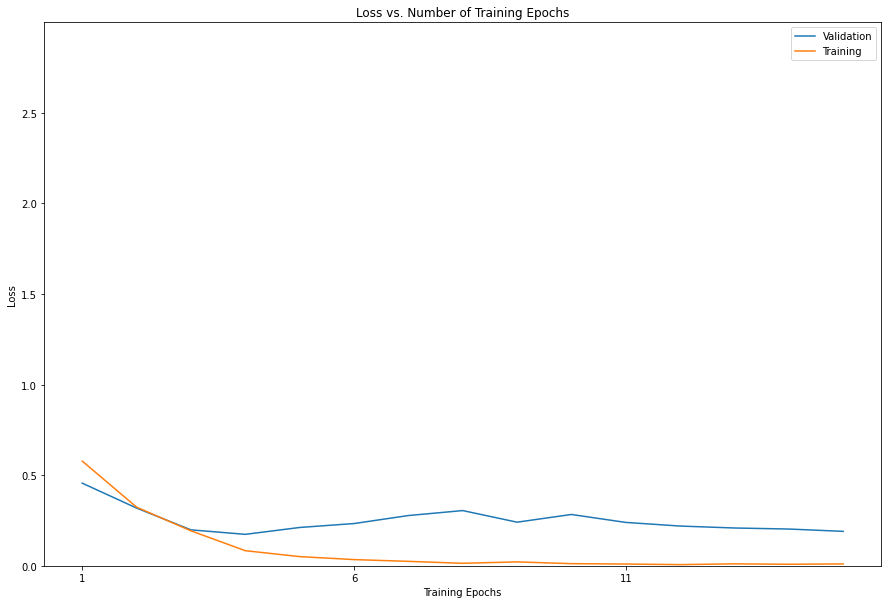

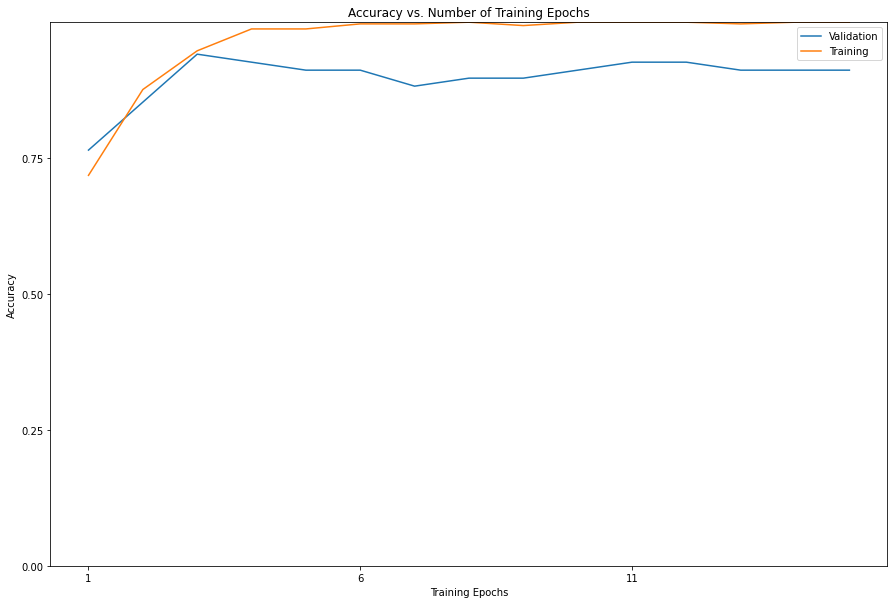

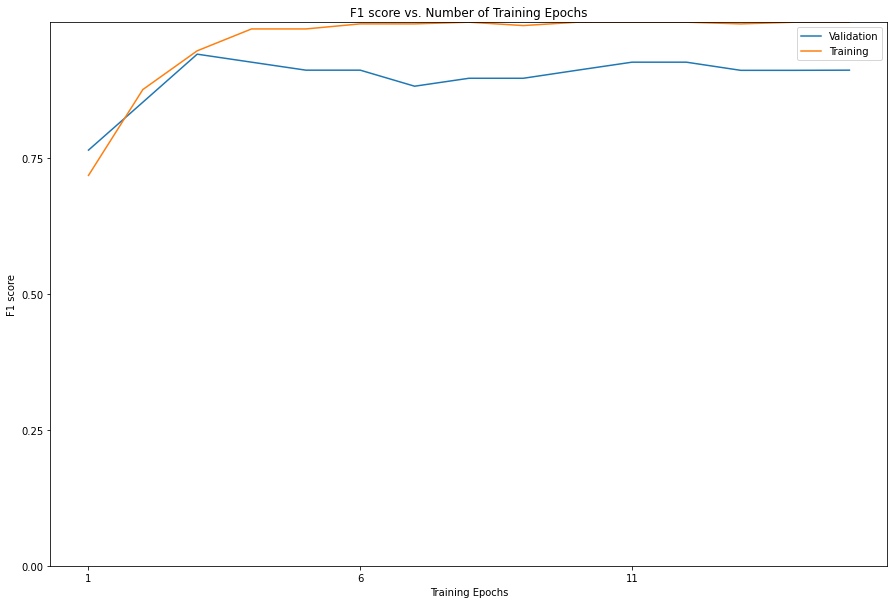

Confusion matrix at best acc: 


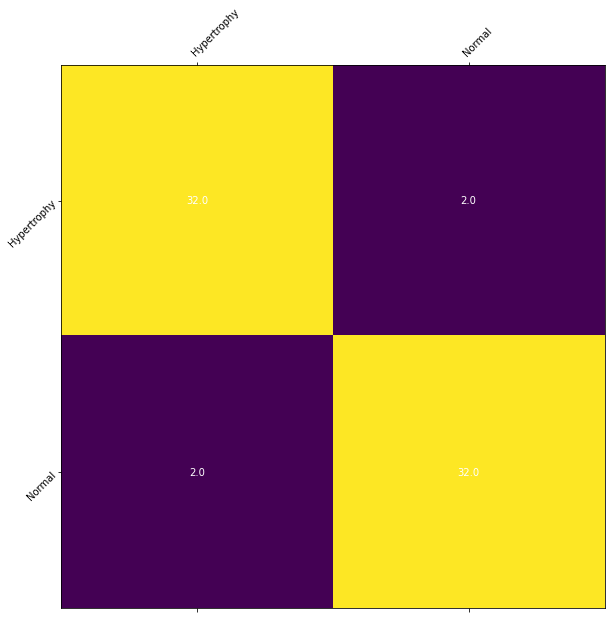

Confusion matrix at best F1 score: 


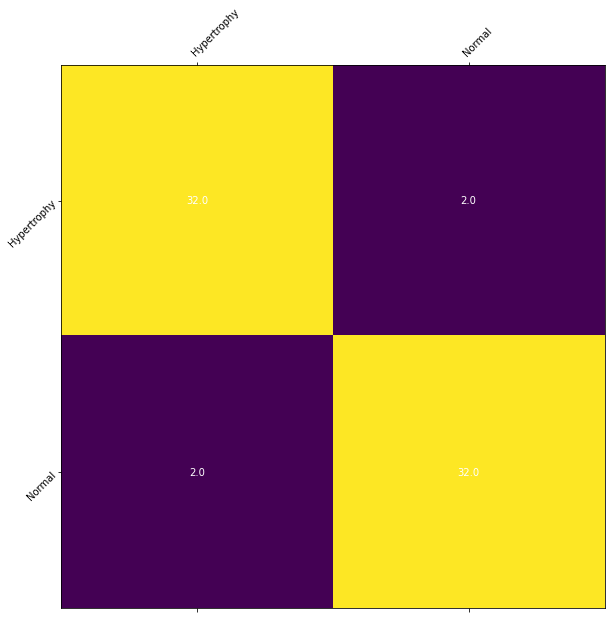

Confusion matrix at best F1 score: 


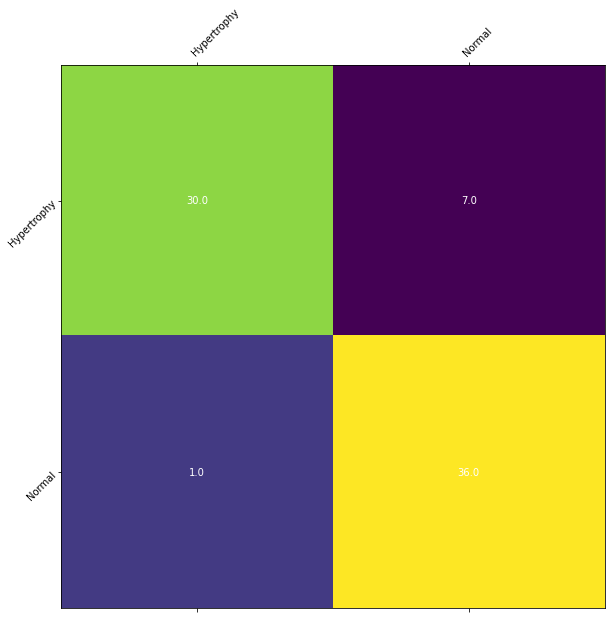

In [ ]:

print('Seed for the run: {}'.format(torch.seed()))

set_seed()

# Train and evaluate
(classModel, val_acc_hist, train_acc_hist, val_f1_hist, train_f1_hist,
 val_loss_hist, train_loss_hist, best_acc_preds, best_acc_targets,
  best_f1_preds, best_f1_targets, best_loss_preds,
   best_loss_targets) = train_classification(ensembleModel, dataloaders_dict,
                                            criterion, optimizer,
                                            scheduler, num_epochs=num_epochs)
   
print('Seed for the run: {}'.format(torch.seed()))

set_seed()

test_preds, test_targets = testModel(classModel, testDataLoader)

val_acc_hist = [h.cpu().numpy() for h in val_acc_hist]
train_acc_hist = [h.cpu().numpy() for h in train_acc_hist]

final_epoch_num = len(val_loss_hist)

fig, ax = plt.subplots()
ax.set_title("Loss vs. Number of Training Epochs")
ax.set_xlabel("Training Epochs")
ax.set_ylabel("Loss")
ax.plot(range(1,final_epoch_num+1),val_loss_hist,label="Validation")
ax.plot(range(1,final_epoch_num+1),train_loss_hist,label="Training")
ax.set_ylim((0,3.))
ax.set_yticks((np.arange(0, 3, 0.5)))
ax.set_xticks(np.arange(1, final_epoch_num+1, 5.0))
ax.legend()
fig.set_size_inches(15,10)
plt.savefig("/content/drive/My Drive/BME/7felev/Szakdolgozat/figs/loss.png", dpi=200)
plt.show()
ax.clear()

fig, ax = plt.subplots()
ax.set_title("Accuracy vs. Number of Training Epochs")
ax.set_xlabel("Training Epochs")
ax.set_ylabel("Accuracy")
ax.plot(range(1,final_epoch_num+1),val_acc_hist,label="Validation")
ax.plot(range(1,final_epoch_num+1),train_acc_hist,label="Training")
ax.set_ylim((0,1.))
ax.set_yticks((np.arange(0, 1, 0.25)))
ax.set_xticks(np.arange(1, final_epoch_num+1, 5.0))
ax.legend()
fig.set_size_inches(15,10)
plt.savefig("/content/drive/My Drive/BME/7felev/Szakdolgozat/figs/acc.png", dpi=200)
plt.show()
ax.clear()

fig, ax = plt.subplots()
ax.set_title("F1 score vs. Number of Training Epochs")
ax.set_xlabel("Training Epochs")
ax.set_ylabel("F1 score")
ax.plot(range(1,final_epoch_num+1),val_f1_hist,label="Validation")
ax.plot(range(1,final_epoch_num+1),train_f1_hist,label="Training")
ax.set_ylim((0,1.))
ax.set_yticks((np.arange(0, 1, 0.25)))
ax.set_xticks(np.arange(1, final_epoch_num+1, 5.0))
ax.legend()
fig.set_size_inches(15,10)
plt.savefig("/content/drive/My Drive/BME/7felev/Szakdolgozat/figs/f1.png", dpi=200)
plt.show()
ax.clear()

# print('Confusion matrix at best loss: ')

# confusion_matrix = np.zeros((num_classes, num_classes))
# for idx in range(len(best_loss_targets)):
#     target = best_loss_targets[idx]

#     output = best_loss_preds[idx]
#     # output = list(output).index(max(output))

#     confusion_matrix[output][target] += 1

# fig, ax = plt.subplots(1)

# ax.matshow(confusion_matrix)
# ax.set_xticks(np.arange(num_classes))
# ax.set_yticks(np.arange(num_classes))

# ax.set_xticklabels(patient_datasets['validation'].classes)
# ax.set_yticklabels(patient_datasets['validation'].classes)

# for (i, j), z in np.ndenumerate(confusion_matrix):
#   ax.text(i, j, z, ha='center', va='center', color='w')

# plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
# plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# fig.set_size_inches(15,10)

# plt.savefig("/content/drive/My Drive/BME/7felev/Szakdolgozat/figs/confusion_loss.png", dpi=200)
# plt.show()

print('Confusion matrix at best acc: ')

confusion_matrix = np.zeros((num_classes, num_classes))
for idx in range(len(best_acc_targets)):
    target = best_acc_targets[idx]

    output = best_acc_preds[idx]
    # output = list(output).index(max(output))

    confusion_matrix[output][target] += 1

fig, ax = plt.subplots(1)

ax.matshow(confusion_matrix)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))

ax.set_xticklabels(patient_datasets['validation'].classes)
ax.set_yticklabels(patient_datasets['validation'].classes)

for (i, j), z in np.ndenumerate(confusion_matrix):
  ax.text(i, j, z, ha='center', va='center', color='w')

plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fig.set_size_inches(15,10)

plt.savefig("/content/drive/My Drive/BME/7felev/Szakdolgozat/figs/confusion_acc.png", dpi=200)
plt.show()

print('Confusion matrix at best F1 score: ')

confusion_matrix = np.zeros((num_classes, num_classes))
for idx in range(len(best_f1_targets)):
    target = best_f1_targets[idx]

    output = best_f1_preds[idx]
    # output = list(output).index(max(output))

    confusion_matrix[output][target] += 1

fig, ax = plt.subplots(1)

ax.matshow(confusion_matrix)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))

ax.set_xticklabels(patient_datasets['validation'].classes)
ax.set_yticklabels(patient_datasets['validation'].classes)

for (i, j), z in np.ndenumerate(confusion_matrix):
  ax.text(i, j, z, ha='center', va='center', color='w')

plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fig.set_size_inches(15,10)

plt.savefig("/content/drive/My Drive/BME/7felev/Szakdolgozat/figs/confusion_f1.png", dpi=200)
plt.show()


print('Confusion matrix at best F1 score: ')

confusion_matrix = np.zeros((num_classes, num_classes))
for idx in range(len(test_targets)):
    target = test_targets[idx]

    output = test_preds[idx]
    # output = list(output).index(max(output))

    confusion_matrix[output][target] += 1

fig, ax = plt.subplots(1)

ax.matshow(confusion_matrix)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))

ax.set_xticklabels(patient_datasets['validation'].classes)
ax.set_yticklabels(patient_datasets['validation'].classes)

for (i, j), z in np.ndenumerate(confusion_matrix):
  ax.text(i, j, z, ha='center', va='center', color='w')

plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fig.set_size_inches(15,10)

plt.savefig("/content/drive/My Drive/BME/7felev/Szakdolgozat/figs/confusion_test.png", dpi=200)
plt.show()
